# Fast Gradient Sign Method

Add a brief description here

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack


This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

\begin{equation}
\tag{1.1}
\widetilde{x} = x + \eta
\end{equation}

\begin{equation}
\tag{1.2}
\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))
\end{equation}



In [4]:
def compare_examples_fgsm(epsilon, idx):
    '''
    Generates an example using FGSM. Prints infos and plots clean and adversarial image side-by-side
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    '''
    
    ## Get data
    image_clean, target_label = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_label.unsqueeze_(0)
    image_clean = image_clean.cpu()
    target_label = target_label.cpu()
    model.cpu()

    ## Predict clean example
    gradient, _, _, conf_clean, label_clean = predict(model, image_clean, target_label, return_grad=True)

    ## Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, epsilon, gradient)
    _, _, _, conf_adv, label_adv = predict(model, image_adv, target_label, return_grad=False)

    ## Plot
    plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_label)

In [5]:
def apply_fgsm(image, epsilon, grad_x):
    '''
    Generates adversarial image from the input image using the Fast Gradient Sign Method (FGSM).
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    ## Compute eta part
    eta = eps_normed * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta    
    
    ## Clip image to maintain the range [min, max]
    image_tilde = torch.clamp(image_tilde, image.detach().min(), image.detach().max())
    
    ## Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1)
    
    ## Clip image so after denormalization and destandardization, the range is [0, 255]
    image_tilde = torch.max(image_tilde, zero_normed)
    image_tilde = torch.min(image_tilde, max_normed)
    
    return image_tilde

### 2.1 Individual Images

Do some cool analysis here. In particularm find one of the examples where a wrong class is predicted with high confidence. Apparently there aren't neccessarily that many in the ImageNet dataset?

			Clean image	 Adversarial image

Actual class: 		church, church building			church, church building
Predicted class: 	church, church building			patio, terrace
Confidence: 		72.01%				27.60%



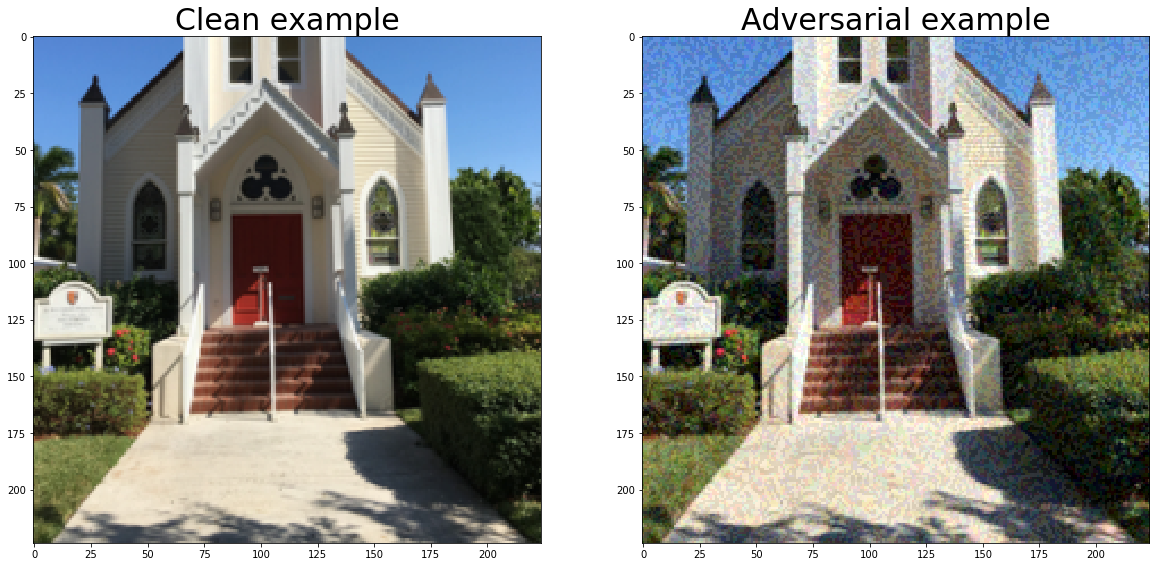

In [9]:
## Random example for smaller epsilon
epsilon = 11/255
idx = 825

compare_examples_fgsm(epsilon, idx)

In [ ]:
## Random example for larger epsilon
epsilon = 12/255
idx = 440

compare_examples_fgsm(epsilon, idx)

It can be seen that from a value of around $\epsilon = \frac{10}{255}$ the pertubation becomes visible to the human eye. Note that the model predicts a different class here with a very low confidence.

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

In [ ]:
# Set perturbation
epsilons = [0, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]


accurcy_top1 = []
accurcy_top5 = []
confidence_adversarial = []


for epsilon in epsilons:   
    acc_sub_adver_top1 = []
    acc_sub_adver_top5 = []
    conf_sub_adver = []    
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon*255))
        print("Sample: "+ str(i))
        print("Accuracy adversarial: {:.2f}".format(np.mean(acc_sub_adver_top1)))
        print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))
        
        # Predict with clean image
        gradient, corr, _, _, _ = predict(model, image_as_tensor, label, return_grad=True)

        # Generate adversarial example only if initial prediction was correct
        if corr == 1:            
            # Predict with adversarial image
            perturbed_data = apply_fgsm(image_as_tensor, epsilon, gradient)
            _, top1, top5, conf, _ = predict(model, perturbed_data, label)
            acc_sub_adver_top1.append(top1)
            acc_sub_adver_top5.append(top5)
            conf_sub_adver.append(conf)
            
        else:
            acc_sub_adver_top1.append(0)
            acc_sub_adver_top5.append(0)
            conf_sub_adver.append(0)
    
        i += 1
        
    # Add accuracies and confidences for clean and adversarial example
    accurcy_top1.append(np.mean(acc_sub_adver_top1))
    accurcy_top5.append(np.mean(acc_sub_adver_top5))
    confidence_adversarial.append(np.mean(conf_sub_adver))

   
## Save results
result = pd.DataFrame()
epsilon = np.array(epsilons) * 255
result["Epsilon_255"] = epsilon
result["Accuracy Top 1"] = accurcy_top1
result["Accuracy Top 5"] = accurcy_top5
result["Confidence"] = confidence_adversarial
result.to_csv("results/googleNet_ImageNet_FGSM_2.csv")

## 3. Discussion

In [ ]:
# Load results
result = pd.read_csv("results/googleNet_ImageNet_FGSM.csv")
accurcy_top1 = result["Accuracy Top 1"]
accurcy_top5 = result["Accuracy Top 5"]
confidence_adversarial = result["Confidence"]
epsilon = result["Epsilon_255"]

In [ ]:
plt.plot(epsilon, accurcy_top1, "s-", color="navy", label="Top 1")
plt.plot(epsilon, accurcy_top5, "o-", color="navy", label="Top 5")
plt.plot(epsilon, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on ImageNet Dev Set", fontsize=30)
plt.legend()
plt.show()

#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM2.pdf")
#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM2.png")

Some text ...

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*